<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Exercise%20Solutions/%F0%9F%9B%A0%20%2005_Transfer_Learning_in_TensorFlow_Part_2_Fine_tuning_Exercise_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛠 05. Transfer Learning in TensorFlow Part 2: Fine-tuning Exercise Solutions 

# Questions 

1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using [`tf.keras.applications.EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) as the base model. Use the [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save the weights to file.

2. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?

3. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?

4. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.



# Getting the data and setting things up (Food vision 10% data) 

In [ ]:
# importing required libraries 
import tensorflow as tf 
import tensorflow.keras.layers as layers
import tensorflow.keras.callbacks as callbacks
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [ ]:
# Getting the helper functions 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import plot_loss_curves, unzip_data, compare_historys, walk_through_dir

--2021-07-06 19:21:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-06 19:21:35 (114 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# getting the data 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2021-07-06 18:51:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.141.128, 2607:f8b0:4023:c03::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   127MB/s    in 1.3s    

2021-07-06 18:51:31 (127 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# extracting data 
!unzip 10_food_classes_10_percent.zip

In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [ ]:
# Getting our train and test directory 
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'


train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    label_mode = 'categorical',
    image_size = (224,224)
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir, 
    label_mode = 'categorical',
    image_size = (224,224)
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.



## 1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using [`tf.keras.applications.EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) as the base model. Use the [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save the weights to file.

In [ ]:
# Create checkpoint callback to save model for later use
checkpoint_path = "food_vision_checkpoint/"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True) 

In [ ]:
# Setting the base model layers as trainable to fine tune the model 

base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False 

In [ ]:
# taking inputs 
inputs = tf.keras.layers.Input(shape = (224,224,3)) # here 3 is no of color channels 
x = base_model(inputs)

# passing inputs through GlobalMaxPool2D for maxpooling and reducing the dimensions 
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# making the output layer 
outputs = tf.keras.layers.Dense(10,activation = 'softmax')(x)

# putting the model together with tf.keras.Model 
model = tf.keras.Model(inputs, outputs)

In [ ]:
# model's summary 
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1280)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Compiling the model 
model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                     metrics=['accuracy'])


In [ ]:
# Fitting the model on 5 epochs and saving weights using ModelCheckpointCallback
initial_epochs = 3
history = model.fit(train_data,
                    epochs= initial_epochs,
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks = [checkpoint_callback])

Epoch 1/3
24/24 [==============================] - 16s 498ms/step - loss: 1.9294 - accuracy: 0.3600 - val_loss: 1.3443 - val_accuracy: 0.7184
Epoch 2/3
24/24 [==============================] - 11s 451ms/step - loss: 1.1795 - accuracy: 0.7213 - val_loss: 0.9255 - val_accuracy: 0.7956
Epoch 3/3
24/24 [==============================] - 11s 447ms/step - loss: 0.8517 - accuracy: 0.7987 - val_loss: 0.7503 - val_accuracy: 0.8280


## 2. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?

In [ ]:
# Checking the model 
for no,layer in enumerate(model.layers):
  print(no,layer.name, layer.trainable)

0 input_17 True
1 efficientnetb0 False
2 global_average_pooling2d_7 True
3 dense_7 True


In [ ]:
# Fine tuning the model (unfreezing all the layer and refreezing everything excpet the last 20 layers)
base_model.trainable = True

# # Refreeze every layer except for the last 20
for layer in base_model.layers[:-20]:
  layer.trainable = False

In [ ]:
# Checking the layers are trainable 
for num , layer in enumerate(base_model.layers):
  print(num , layer.name, layer.trainable)

0 input_16 False
1 rescaling_8 False
2 normalization_8 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resh

In [ ]:
# Re-compiling model for fine tuning 
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics = ['accuracy'])

In [ ]:
# Fitting our model for fine tuning 
fine_tune_epochs = initial_epochs + 10

history_fine_tune_model = model.fit(train_data, 
          epochs = fine_tune_epochs ,
          steps_per_epoch=len(train_data),
          validation_data = test_data , 
          validation_steps = len(test_data),
          initial_epoch =history.epoch[-1])

Epoch 3/13
24/24 [==============================] - 17s 499ms/step - loss: 1.1717 - accuracy: 0.7093 - val_loss: 0.6420 - val_accuracy: 0.8264
Epoch 4/13
24/24 [==============================] - 11s 455ms/step - loss: 0.8381 - accuracy: 0.8187 - val_loss: 0.5802 - val_accuracy: 0.8336
Epoch 5/13
24/24 [==============================] - 11s 454ms/step - loss: 0.6472 - accuracy: 0.8693 - val_loss: 0.5415 - val_accuracy: 0.8408
Epoch 6/13
24/24 [==============================] - 11s 456ms/step - loss: 0.5144 - accuracy: 0.9053 - val_loss: 0.5098 - val_accuracy: 0.8484
Epoch 7/13
24/24 [==============================] - 11s 453ms/step - loss: 0.4303 - accuracy: 0.9120 - val_loss: 0.4876 - val_accuracy: 0.8528
Epoch 8/13
24/24 [==============================] - 11s 451ms/step - loss: 0.3662 - accuracy: 0.9387 - val_loss: 0.4690 - val_accuracy: 0.8580
Epoch 9/13
24/24 [==============================] - 11s 452ms/step - loss: 0.3057 - accuracy: 0.9480 - val_loss: 0.4570 - val_accuracy: 0.8632

In [ ]:
# Evaluating on the test data 
results_last_20_layers_model = model.evaluate(test_data)
results_last_20_layers_model

79/79 [==============================] - 9s 105ms/step - loss: 0.4223 - accuracy: 0.8636


[0.4222880005836487, 0.8636000156402588]

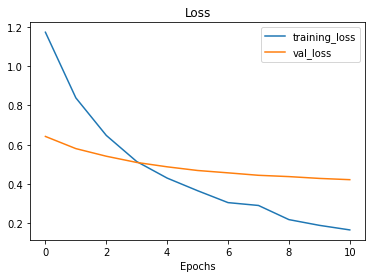

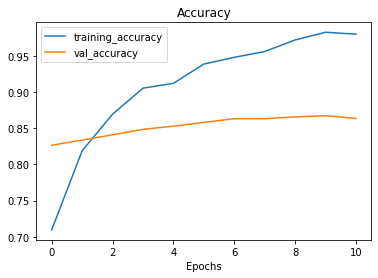

In [ ]:
# Plotting the loss curves 
plot_loss_curves(history_fine_tune_model)

## 3. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?

In [ ]:
# Loading the weights we've saved before in the food vision checkpoint
model.load_weights('food_vision_checkpoint/')

In [ ]:
# Checking the model layers
for no,layer in enumerate(model.layers):
  print(no,layer.name, layer.trainable)

0 input_17 True
1 efficientnetb0 True
2 global_average_pooling2d_7 True
3 dense_7 True


In [ ]:
# Fine tuning the model (unfreezing all the layer and refreezing everything excpet the last 30 layers)
base_model.trainable = True

# Refreeze every layer except for the last 30
for layer in base_model.layers[:-30]:
  layer.trainable = False

In [ ]:
for num , layer in enumerate(base_model.layers):
  print(num,layer.name, layer.trainable)

0 input_16 False
1 rescaling_8 False
2 normalization_8 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resh

In [ ]:
# Re-compiling model for fine tuning 
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics = ['accuracy'])

In [ ]:
# Fitting the model for fine tuning 

fine_tune_epochs = initial_epochs + 10
history_fine_tune_model_30 = model.fit(train_data, 
                                      epochs = fine_tune_epochs ,
                                      steps_per_epoch=len(train_data),
                                      validation_data = test_data , 
                                      validation_steps = len(test_data),
                                      initial_epoch =history.epoch[-1])

Epoch 3/13
24/24 [==============================] - 17s 506ms/step - loss: 1.2410 - accuracy: 0.6813 - val_loss: 0.6411 - val_accuracy: 0.8296
Epoch 4/13
24/24 [==============================] - 11s 462ms/step - loss: 0.8763 - accuracy: 0.8227 - val_loss: 0.5798 - val_accuracy: 0.8344
Epoch 5/13
24/24 [==============================] - 11s 458ms/step - loss: 0.6670 - accuracy: 0.8680 - val_loss: 0.5366 - val_accuracy: 0.8388
Epoch 6/13
24/24 [==============================] - 11s 456ms/step - loss: 0.5471 - accuracy: 0.8853 - val_loss: 0.5096 - val_accuracy: 0.8460
Epoch 7/13
24/24 [==============================] - 11s 456ms/step - loss: 0.4465 - accuracy: 0.9040 - val_loss: 0.4893 - val_accuracy: 0.8504
Epoch 8/13
24/24 [==============================] - 11s 456ms/step - loss: 0.3670 - accuracy: 0.9333 - val_loss: 0.4734 - val_accuracy: 0.8568
Epoch 9/13
24/24 [==============================] - 11s 459ms/step - loss: 0.3085 - accuracy: 0.9507 - val_loss: 0.4593 - val_accuracy: 0.8564

You may have noticed that compared to learning on the 20 layers 30 layers unfreezing didn't brought any significant changes.


## 4. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

In [ ]:
# Creating a function that would grab the image from a dataset, visualize and gives the prediction of it. 

def dataset_visualizer(dataset , model):
  '''
  Arguments: 
    dataset --> `tf.data.Dataset` object with (image , label) tuples 
    model --> the trained model 

  Returns: 
    Visualizae the image from the dataset and the prediction class of the image. 
  '''
  image_batch , label_batch = dataset.as_numpy_iterator().next() 
  batch_prob = [model.predict(tf.expand_dims(img , axis = 0)) for img in image_batch]
  batch_preds = [class_names[np.argmax(prob)] for prob in batch_prob]

  plt.figure(figsize= (10 , 10))
  for i in range(4):
    ax = plt.subplot(2 , 2 , i + 1)
    if class_names[np.argmax(label_batch[i])] == batch_preds[i]:
      title_color = 'g'
    else:
      title_color = 'r'
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(f"actual: {class_names[np.argmax(label_batch[i])]}, pred: {batch_preds[i]}, prob: {batch_prob[i].max():.2f}" , c = title_color)
    plt.axis('off')
    

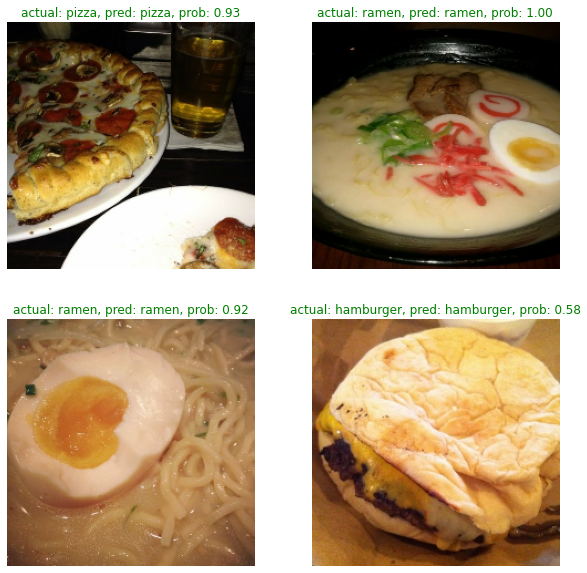

In [ ]:
dataset_visualizer(test_data , model)